<br>
<font color="#500000" size=15 style="margin:2cm"> AGGREGATIBACTER FUSE</font>



In [1]:
# importing modules
import matplotlib.pyplot as plt
import numpy as np
from skfusion import fusion
from cross_validation import *
import pickle

from scipy.stats import ranksums
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

#Matrices import

Load in all the matrices!

In [2]:
prot_rna = pickle.load(open('../matrices/pickles/cr_z-score_raw.pkl', 'rb'))
secretion_prot = pickle.load(open('../matrices/pickles/signalP.pkl', 'rb'))
rna_expression = pickle.load(open('../matrices/pickles/MA_exp.pkl', 'rb'))
s4te_prot = np.load(open('../matrices/pickles/S4TE.npy', 'rb'))
OG_prot = np.load(open('../matrices/pickles/OG_prot.npy', 'rb')) # this is orthology function
rna_GO = np.load(open('../matrices/pickles/HSgene_GO.npy', 'rb'))

gproOG_prot = np.load(open('../matrices/pickles/aaprot_gprobOG.npy', 'rb'))
hsgene_gproOG = np.load(open('../matrices/pickles/HSgene_GO.npy', 'rb'))
aaexp_prot = np.load(open('../matrices/pickles/aa_fc_expressions.npy', 'rb'))

# Data transformation

In [3]:
# remove data for genes with no catrapid prediction
selection = prot_rna.any(axis=1)
prot_rna = prot_rna[selection,:]
secretion_prot = secretion_prot[:, selection]
s4te_prot = s4te_prot[:, selection]
OG_prot = OG_prot[:, selection]
gproOG_prot = gproOG_prot.T[:, selection]
# Addd pseudo rows 
# TODO: remove when fixed!
secretion_prot = np.vstack((secretion_prot, secretion_prot, secretion_prot, secretion_prot, secretion_prot))

rna_expression = rna_expression.reshape(rna_expression.shape[0],1)
rna_expression = np.hstack((rna_expression, rna_expression, rna_expression, rna_expression, rna_expression))

aaexp_prot = np.reshape(aaexp_prot, (1, aaexp_prot.size))
aaexp_prot = np.vstack((aaexp_prot, aaexp_prot, aaexp_prot, aaexp_prot, aaexp_prot))[:, selection]

# Add sum to S4te Results
s4te_prot[1,:] = s4te_prot[1,:] * 3
s4te_sum = s4te_prot.sum(axis=0) / s4te_prot.sum(axis=0).max()
s4te_prot = np.vstack((s4te_prot,s4te_sum))

# Display shapes
print('secretion_prot:', secretion_prot.shape)
print('rna_expression:', rna_expression.shape)
print('prot_rna:', prot_rna.shape)
print('s4te_prot:', s4te_prot.shape)
print('OG_prot:', OG_prot.shape)
print('gproOG_prot', gproOG_prot.shape)
print('hsgene_gproOG', gproOG_prot.shape)
print('aaexp_prot', aaexp_prot.shape)
print('rna_GO', rna_GO.shape)

secretion_prot: (5, 2001)
rna_expression: (7097, 5)
prot_rna: (2001, 7097)
s4te_prot: (13, 2001)
OG_prot: (22, 2001)
gproOG_prot (825, 2001)
hsgene_gproOG (825, 2001)
aaexp_prot (5, 2001)
rna_GO (7097, 285)


# Data fusion setup

In [4]:
# Define names
secretion = fusion.ObjectType('SignalP')
prot = fusion.ObjectType('AAprot')
genes = fusion.ObjectType('HSgenes')
GO = fusion.ObjectType('GOterms')

# TODO: lower when possible
expr = fusion.ObjectType('HSexpression')
t4e = fusion.ObjectType('Type4eff')
OGfg = fusion.ObjectType('ontology_group_functions')
gproOG = fusion.ObjectType('ontology_groups')
aaexp = fusion.ObjectType('AAexpression')
# Define relations
relations = [fusion.Relation(secretion_prot, secretion, prot),
             fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_expression, genes, expr),
             fusion.Relation(OG_prot, OGfg, prot),
             fusion.Relation(gproOG_prot, gproOG, prot),
             fusion.Relation(hsgene_gproOG, genes, gproOG),
             fusion.Relation(aaexp_prot, aaexp, prot),
             fusion.Relation(rna_GO, genes, GO)]



# Validation Functions

In [5]:
def shuffle_rows(my_array, ssed = 100):
    """
    Returns array with rows shuffled
    """
    np.random.seed(ssed)
    sh_idx = np.arange(my_array.shape[0])
    np.random.shuffle(sh_idx)
    return my_array[sh_idx,:]

def shuffle_cols(my_array, ssed = 100):
    """
    Returns array with rows shuffled
    """
    np.random.seed(ssed)
    sh_idx = np.arange(my_array.shape[1])
    np.random.shuffle(sh_idx)
    return my_array[:, sh_idx]


def make_sublot(splot, val1, val2, title=None, abline=None, disleg=False):
    """
    Creates subplot
    """
    splot.text(0.01,0.01, 'P vrednost: {:.5f} (Wilcoxonov test)'
               .format(ranksums(val1, val2)[1]), transform=splot.transAxes)
    if title:
        splot.set_title(title)
    splot.plot([1]*len(val1), val1, 'or');
    
    
    splot.plot([1.1]*len(val2), val2, 'ob');
    splot.set_xlim(0.9, 1.2);
    
    # Samples average
    splot.plot([1], np.mean(val1), 'og', label='Povprečna vrednost')
    splot.plot([1.1], np.mean(val2), 'og')
    
    # Pure average
    if abline:
        splot.plot([0.9, 1.2], [abline]*2, 'k', label='Povprečje brez dodatnih virov')
    if disleg:
        splot.legend(bbox_to_anchor=(1.05, 1), loc=2)
    # splot.legend(loc = 'best')
        
def make_graphs(auc1, auc2, dev1=None, dev2=None, abline1=None, abline2=None):
    """
    Creates validation plot
    """
    if dev1:
        splot = plt.subplot(1, 2, 1)
    else: 
        splot = plt.subplot(1, 1, 1)
    plt.xticks([1,1.1], ['Podatki', 'Permutacija\nPodatkov'], rotation='vertical');
    make_sublot(splot, auc1, auc2, title='AUC vrednosti', abline=abline1)
    
    if dev1:
        splot = plt.subplot(1, 2, 2)
        plt.xticks([1,1.1], ['Podatki', 'Permutacija\nPodatkov'], rotation='vertical');
        make_sublot(splot, dev1, dev2, title='Absolutna napaka', abline=abline2, disleg=True)
        
def row_cross_validate(relations, cv_fold=10, th=2.5, random_state=1, shuffle_test=None, graphlines = [None, None]):
    """
    Performs cross valiation on give first matrix of relation and 
    returns average AUC score and average deviation.
    """
    auc_vals = []
    avr_dev = []
    orig_matrix = relations[0].data
    for cv_matrix, elements in matrix_cv_setup(orig_matrix, n_fold=cv_fold, alternative=0, by_row=True):
        relations[0].data = cv_matrix
        reconst_mat = dfmf_n_reconstruct(relations, random_state=random_state)
        auc_vals.append(auc_value(orig_matrix, reconst_mat, elements, treshold=th, by_row=True))
        avr_dev.append(avr_res(orig_matrix, reconst_mat, elements, by_row=True))

    print('\tAUC value is:', np.mean(auc_vals))
    print('\t\tall values:', auc_vals)
    print()
    print('\tAverage deviation is:', np.mean(avr_dev))
    print('\t\tall values:', avr_dev)
    relations[0].data = orig_matrix
    
    if shuffle_test:
        auc_vals2 = []
        avr_dev2 = []
        if len(relations) > 2:
            print('Sorry, can not handle this for now!' )
            return 
        elif  shuffle_test == 'row':
            relations[1].data = shuffle_rows(relations[1].data)
        
        elif shuffle_test == 'col': 
            relations[1].data = shuffle_cols(relations[1].data)
        else:
            print('Unknown shuffle test')
            return 
        # print(relations[1].data)
        print('\n\nShuffling by {}'.format(shuffle_test))
        for cv_matrix, elements in matrix_cv_setup(orig_matrix, n_fold=cv_fold, alternative=0, by_row=True):
            relations[0].data = cv_matrix
            reconst_mat = dfmf_n_reconstruct(relations, random_state=random_state)
            auc_vals2.append(auc_value(orig_matrix, reconst_mat, elements, treshold=th, by_row=True))
            avr_dev2.append(avr_res(orig_matrix, reconst_mat, elements, by_row=True))

        print('\tAUC value is:', np.mean(auc_vals2))
        print('\t\tall values:', auc_vals2)
        print()
        print('\tAverage deviation is:', np.mean(avr_dev2))
        print('\t\tall values:', avr_dev2)
        relations[0].data = orig_matrix
        make_graphs(auc_vals, auc_vals2, avr_dev, avr_dev2, graphlines[0], graphlines[1])
        
    return np.mean(auc_vals), np.mean(avr_dev)
    
def dfmf_n_reconstruct(relationships, random_state=1):
    """
    Given relationships, reconstructs the matrix
    """
    fusion_graph = fusion.FusionGraph(relations)

    fuser = fusion.Dfmf(random_state=random_state)
    fuser.fuse(fusion_graph)
    return fuser.complete(fusion_graph['catrapid'])


# Predictions and Validations

We are calculating for top 0.6351% interactions
Only Interactions:
	AUC value is: 0.496226219262
		all values: [0.46861601686399329, 0.45028366017259014, 0.44572936877572544, 0.56314669860314892, 0.49069325497714145, 0.59543158293543441, 0.41738269049083071, 0.52627553924356574, 0.48091963614884686, 0.5237837444081701]

	Average deviation is: 0.599167062954
		all values: [0.61176821181724395, 0.60343893572524843, 0.57859313005528812, 0.58926593018552165, 0.58969794069889647, 0.5993876973042922, 0.61833112768536136, 0.59908503133421287, 0.61050600836433633, 0.5915966163656049]


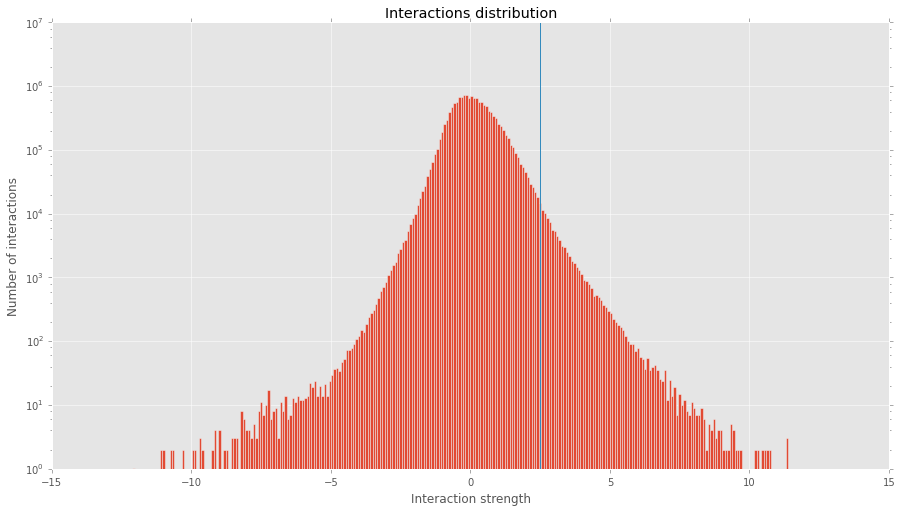

In [6]:
auc_th = 2.5

plt.hist(prot_rna.flatten(), bins= 300, log=True);
plt.plot((auc_th, auc_th), (0, 10**7));
plt.title("Interactions distribution");
plt.xlabel("Interaction strength");
plt.ylabel("Number of interactions");

print('We are calculating for top {:.4f}% interactions'.format(np.sum(prot_rna > auc_th) / prot_rna.size *100))

print('Only Interactions:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid')]
rauc, rdev = row_cross_validate(relations, cv_fold=10, th=auc_th)

with Expression:
	AUC value is: 0.489363768906
		all values: [0.46565872405297898, 0.51527435935137211, 0.51036441139865474, 0.439852334868788, 0.45244994186554882, 0.51812396537907524, 0.45742860709535188, 0.52158992626971989, 0.43798873172658748, 0.57490668705129888]

	Average deviation is: 0.599167069281
		all values: [0.61176822119668439, 0.6034389670182585, 0.57859315322063543, 0.58926598500949379, 0.58969791795216331, 0.59938771028359461, 0.6183311133711723, 0.59908500366918793, 0.61050604981124623, 0.59159657127787424]


Shuffling by row
	AUC value is: 0.487754807807
		all values: [0.4795663642011907, 0.45919827087859455, 0.51566516584848909, 0.44329830665964243, 0.45636511451510242, 0.50916091970008615, 0.45941522550614367, 0.52791894735785183, 0.46574995371748024, 0.5612098096899174]

	Average deviation is: 0.599167068123
		all values: [0.61176822731637426, 0.60343892380079922, 0.57859315963423585, 0.5892659852461769, 0.58969791919372527, 0.5993877132357609, 0.6183311146842546

(0.48936376890593758, 0.59916706928103092)

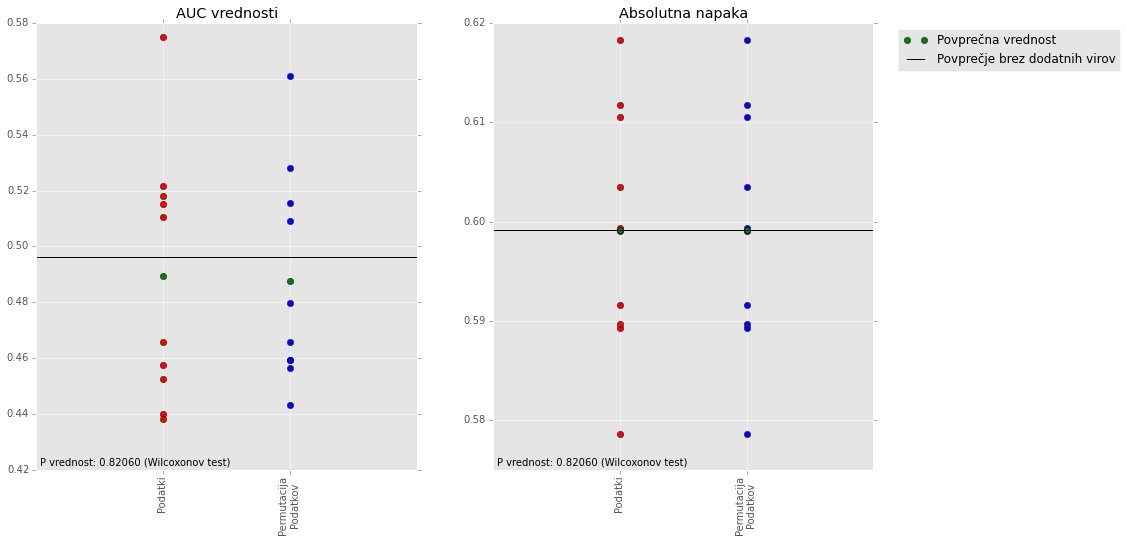

In [7]:
print('with Expression:')

relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_expression, genes, expr)]

row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='row', graphlines = [rauc, rdev])

with Secretion:
	AUC value is: 0.270333918664
		all values: [0.26412711365601838, 0.40237357214630431, 0.23532926430802709, 0.22148205847924129, 0.24871457653515794, 0.22465818071197241, 0.27002488453461349, 0.40517821129033038, 0.20739677261193609, 0.22405455236906016]

	Average deviation is: 0.598881726635
		all values: [0.61138192609220232, 0.60336442868343132, 0.57820957404197171, 0.58873277858897777, 0.5892930866695737, 0.59926927894574555, 0.61813868235892089, 0.59901037841859206, 0.61027391812474097, 0.59114321442425954]


Shuffling by col
	AUC value is: 0.261168137173
		all values: [0.2635858639070342, 0.28771817102760239, 0.23517520817167023, 0.21442879020215003, 0.25507752998340072, 0.23005214004957197, 0.26179015925543253, 0.43077368757739226, 0.19947124343633096, 0.23360857812113367]

	Average deviation is: 0.598814078642
		all values: [0.611278544197709, 0.60336511672111348, 0.57810274699128417, 0.58864910838012974, 0.5891465392569244, 0.59919524941072588, 0.61798621811984

(0.27033391866426609, 0.59888172663484163)

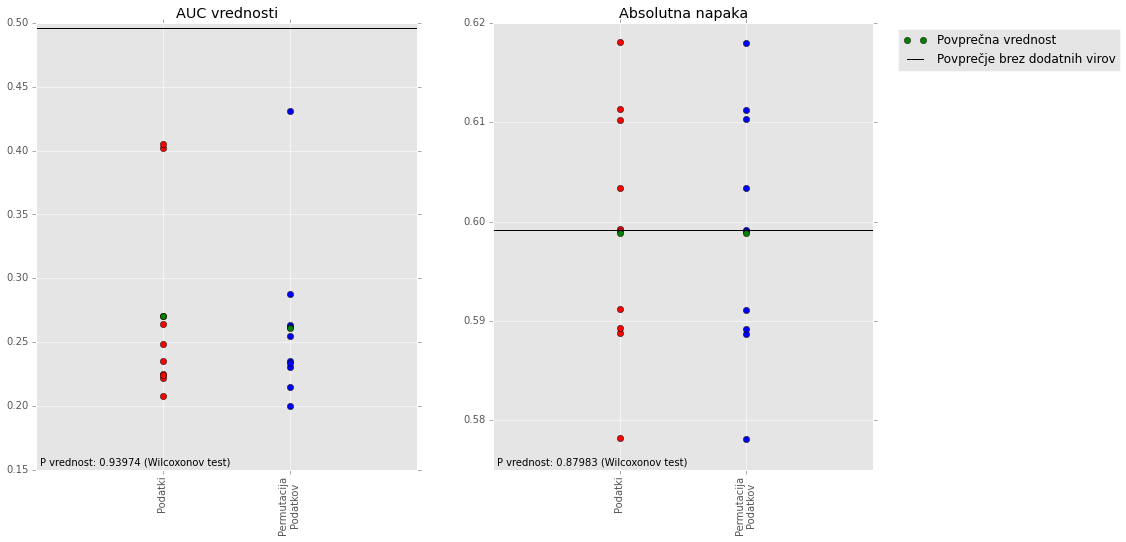

In [8]:
print('with Secretion:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(secretion_prot, secretion, prot)]

row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with S4TE
	AUC value is: 0.383302165758
		all values: [0.45369898387696683, 0.32941023132316716, 0.2871492246706831, 0.46181450746104502, 0.37413491206176253, 0.41579940095351187, 0.40903763966061979, 0.28458596747760267, 0.39589633157100912, 0.42149445852688083]

	Average deviation is: 0.598133288846
		all values: [0.61081852645491419, 0.60228368002232158, 0.57740651361256123, 0.58835032316157698, 0.5885370786425379, 0.59854836875617734, 0.61731900520412697, 0.59808355463732321, 0.6094787609462452, 0.59050707702642502]


Shuffling by col
	AUC value is: 0.409223264485
		all values: [0.35645072110537895, 0.33274948535579452, 0.63046843983367007, 0.53523516809677707, 0.34619178689513286, 0.42378377366953857, 0.38553783648881612, 0.36069334924039692, 0.39235471929354016, 0.32876736487109692]

	Average deviation is: 0.597130570015
		all values: [0.61014409272557446, 0.60198358236900229, 0.57057814244490423, 0.58777387944558168, 0.58836170719371239, 0.59822024722797595, 0.6168970194775264, 

(0.38330216575832493, 0.59813328884642103)

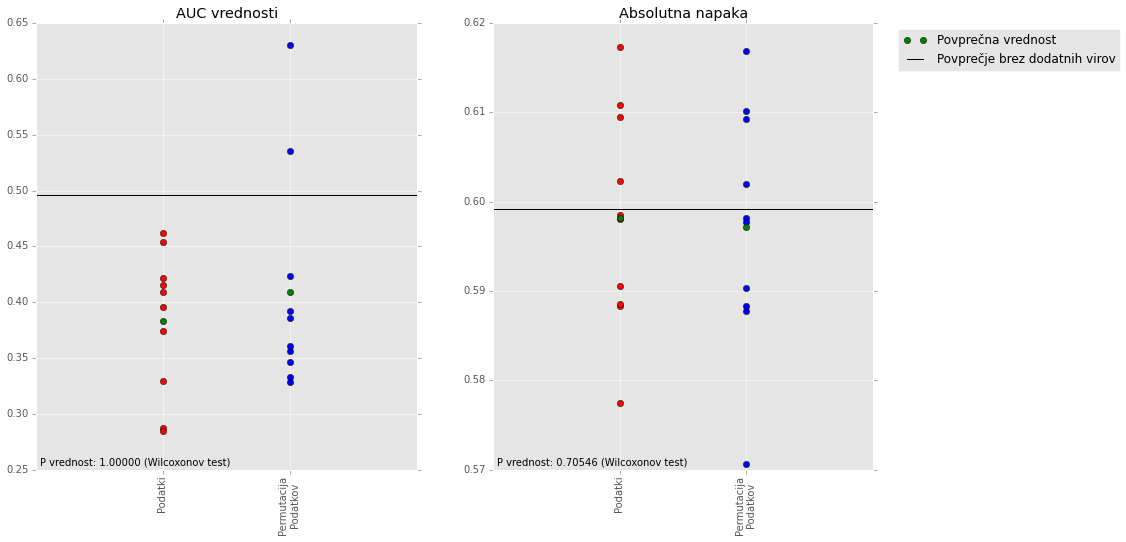

In [9]:
print('with S4TE')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(s4te_prot, t4e, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with AA expression change
	AUC value is: 0.500438974319
		all values: [0.50865559932310889, 0.51194524165516386, 0.48225829521751673, 0.46549326059368817, 0.49699416671626484, 0.5033944671368672, 0.47558768295677273, 0.51356615908053804, 0.5248264407300175, 0.52166842977948591]

	Average deviation is: 0.599313644792
		all values: [0.61180655547292895, 0.60391376658888107, 0.57864345277585605, 0.58934539684547227, 0.58980275777135516, 0.5995536623275125, 0.61841857091909347, 0.59938260895151463, 0.61056722416561915, 0.59170245210125738]


Shuffling by col
	AUC value is: 0.487089493182
		all values: [0.48579523379027628, 0.50747746010861738, 0.46313857481616422, 0.45101530475717305, 0.48603009124432484, 0.4790250599892486, 0.50192898597622659, 0.51468635861370049, 0.48282644748445375, 0.49897141503565606]

	Average deviation is: 0.599311838102
		all values: [0.61180106281420976, 0.60383387382811093, 0.5786491393018306, 0.58927336784568329, 0.58974815110974332, 0.59954998058948994, 0.6183

(0.50043897431894235, 0.59931364479194904)

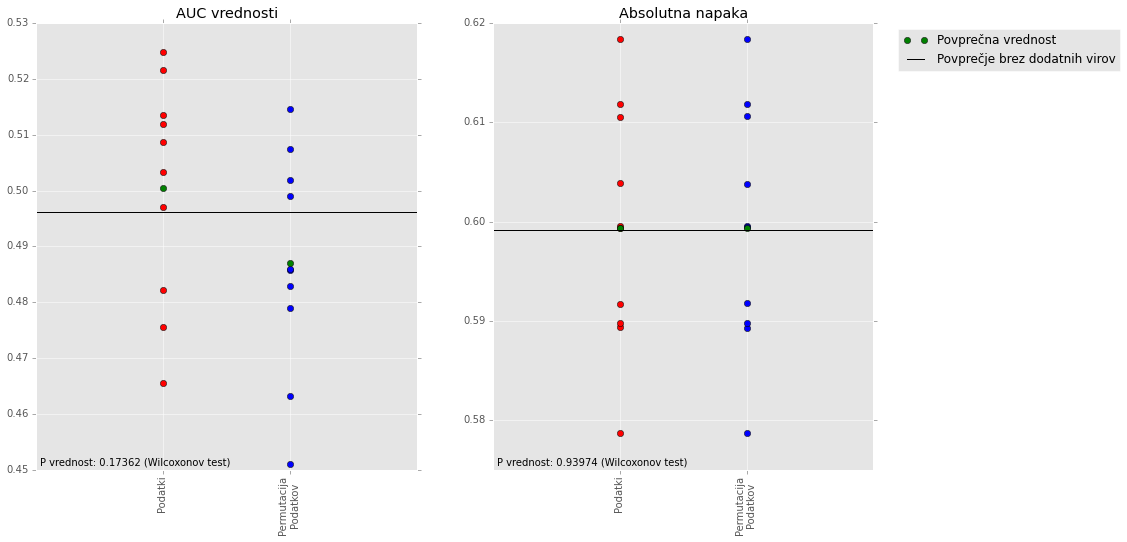

In [10]:
print('with AA expression change')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(gproOG_prot, gproOG, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with Orthology functional groups
	AUC value is: 0.461059961885
		all values: [0.44137066379789192, 0.38720928316297376, 0.44696522162970526, 0.47972040485869388, 0.4230912286205214, 0.53055498973531512, 0.47477889288436548, 0.48645274286858237, 0.4499899080329342, 0.4904662832544906]

	Average deviation is: 0.599273689722
		all values: [0.61111516545491151, 0.60331090476084048, 0.57861716159409338, 0.59032070591104324, 0.58964424608538846, 0.59947570912184478, 0.61856099539209397, 0.59950004718307559, 0.61052901750317756, 0.59166294420922549]


Shuffling by col
	AUC value is: 0.439109248303
		all values: [0.42681160520423811, 0.43385865520821509, 0.43166560038942564, 0.39398362139749277, 0.42847727576855515, 0.47049313586833658, 0.50559053856562852, 0.36423921489414346, 0.45932921479676875, 0.47664362093728863]

	Average deviation is: 0.598990586814
		all values: [0.61199309030465021, 0.6028282940120212, 0.57813632156647221, 0.59055350283191888, 0.58911752715473309, 0.59925802940261019

(0.4610599618845474, 0.59927368972156947)

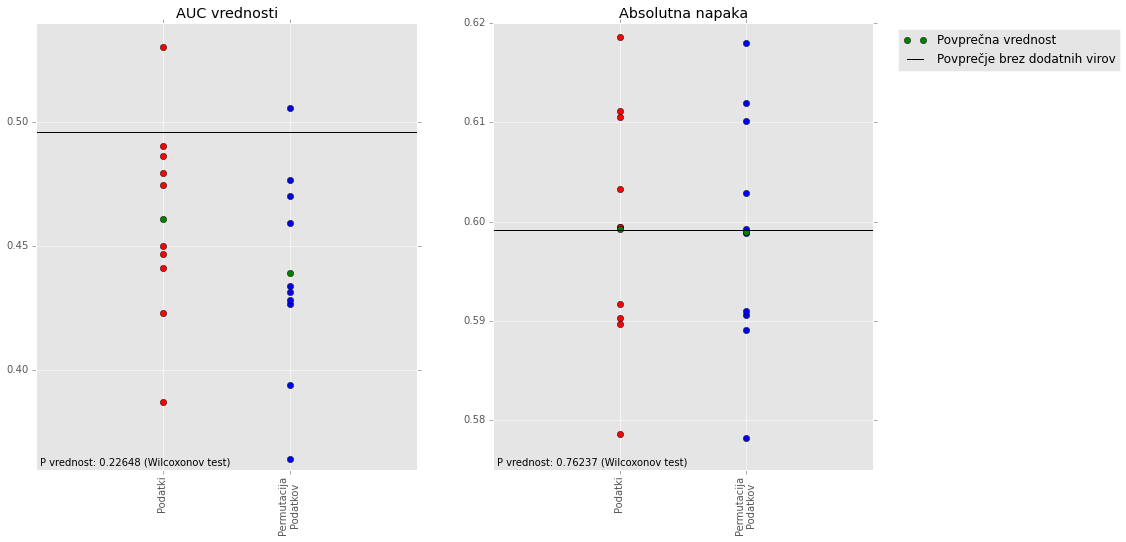

In [11]:
print('with Orthology functional groups')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(OG_prot, OGfg, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])


with GO terms:
	AUC value is: 0.465604644118
		all values: [0.45772371849765098, 0.45705576879652721, 0.47586013742816502, 0.4250890933139409, 0.42717873986398597, 0.55379572220538309, 0.46025566935072454, 0.45833805189161625, 0.50121872029344694, 0.43953081954166623]

	Average deviation is: 0.59916706127
		all values: [0.61176822014988974, 0.6034389304006339, 0.57859314341645884, 0.58926599070110308, 0.58969791801384841, 0.59938763484946367, 0.61833109472330439, 0.59908500178582524, 0.61050605536747815, 0.59159662328991836]


Shuffling by row
	AUC value is: 0.468259713593
		all values: [0.44535701405334482, 0.44502397949182976, 0.4752789701637059, 0.41710816814191337, 0.45767567167752365, 0.55231096815791314, 0.4697590192728362, 0.46071936860020202, 0.49990577473541681, 0.45945820163824797]

	Average deviation is: 0.59916706493
		all values: [0.61176823885122567, 0.60343893023389616, 0.57859314292377451, 0.58926598769367144, 0.58969793069889587, 0.59938765146758366, 0.6183310849755298

(0.46560464411831071, 0.59916706126979236)

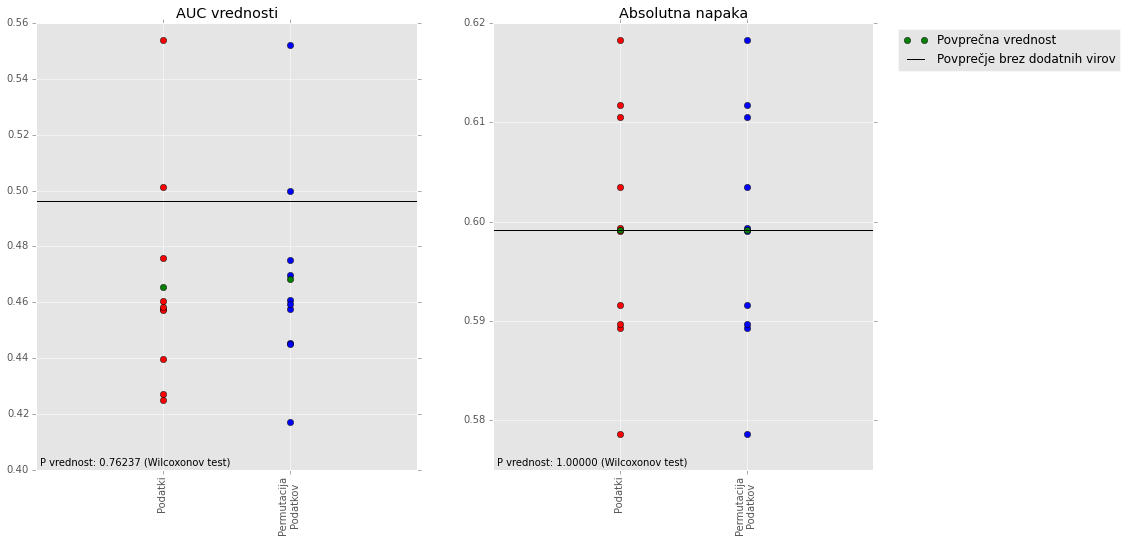

In [12]:
print('with GO terms:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_GO, genes, GO)]

row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='row', graphlines = [rauc, rdev])

with gamma-proteobacter Orthology to AA proteins
	AUC value is: 0.465502075877
		all values: [0.44366774675544052, 0.49130375459013975, 0.45356913031697621, 0.45736096662259562, 0.48083174692500547, 0.50525291870858735, 0.45013984143357277, 0.43201465550523016, 0.43639613154928242, 0.50448386636703113]

	Average deviation is: 0.599143045962
		all values: [0.61176960551936244, 0.60343892100946883, 0.57853622085074607, 0.58923280123825394, 0.58969129513727681, 0.59936102911354894, 0.61829760894725116, 0.59903574406238247, 0.61048007228581547, 0.59158716146042112]


Shuffling by col
	AUC value is: 0.475449064586
		all values: [0.47281874179144673, 0.4687887329362519, 0.47074729363529555, 0.4856775576951769, 0.47708307521274318, 0.47061500785321542, 0.47325075443879444, 0.48084601644209474, 0.49337146591968178, 0.46129199993903769]

	Average deviation is: 0.599127562297
		all values: [0.61174738821478691, 0.60338755374766639, 0.57853253182407338, 0.58922607244647662, 0.58962654384023605, 0

(0.46550207587738618, 0.59914304596245282)

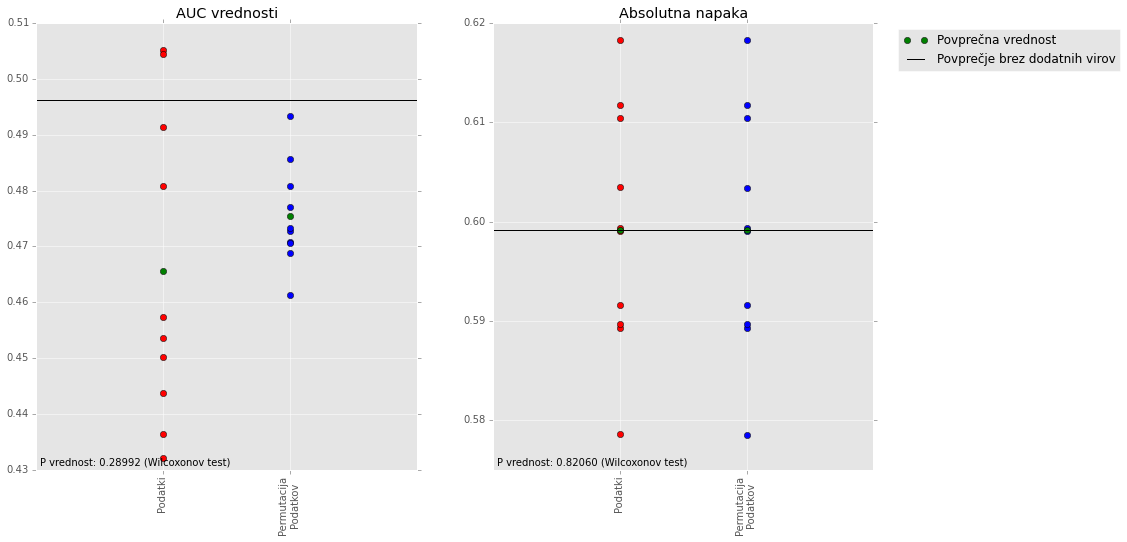

In [13]:
print('with gamma-proteobacter Orthology to AA proteins')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(aaexp_prot, aaexp, prot)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])

with gamma-proteobacter Orthology to HS genes
	AUC value is: 0.465604644118
		all values: [0.45772371849765098, 0.45705576879652721, 0.47586013742816502, 0.4250890933139409, 0.42717873986398597, 0.55379572220538309, 0.46025566935072454, 0.45833805189161625, 0.50121872029344694, 0.43953081954166623]

	Average deviation is: 0.59916706127
		all values: [0.61176822014988974, 0.6034389304006339, 0.57859314341645884, 0.58926599070110308, 0.58969791801384841, 0.59938763484946367, 0.61833109472330439, 0.59908500178582524, 0.61050605536747815, 0.59159662328991836]


Shuffling by col
	AUC value is: 0.462399981561
		all values: [0.42172517276903315, 0.45699116099070686, 0.47579177183469668, 0.42461441459447269, 0.42066467707023675, 0.55434603723523246, 0.47080958364340786, 0.45834241854172481, 0.50121872029344694, 0.43949585863951685]

	Average deviation is: 0.599167063426
		all values: [0.61176824067153068, 0.60343893065464416, 0.57859314443584353, 0.58926598951139986, 0.58969791786051318, 0.599

(0.46560464411831071, 0.59916706126979236)

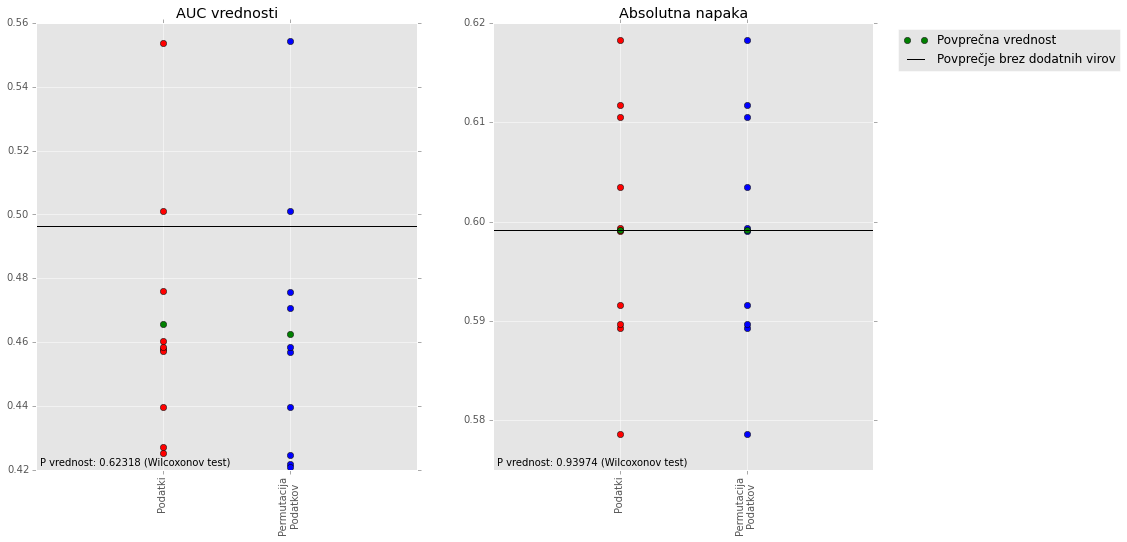

In [14]:
print('with gamma-proteobacter Orthology to HS genes')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(hsgene_gproOG, genes, gproOG)]
row_cross_validate(relations, cv_fold=10, th=auc_th, shuffle_test='col', graphlines = [rauc, rdev])